In [1]:
import os
import sys
import smbus

from time import sleep
from datetime import datetime

In [2]:
# get current working directory and append relative path for package import
if os.name == 'posix':
    _wd = !pwd
    _wd = _wd[0]
elif os.name == 'nt':
    _wd = !cd
    _wd = _wd[0]
else:
    _wd = os.getcwd()
print('Current working directory is:', _wd)
p = os.path.dirname(_wd)
p = os.path.join(p, '.')
p = os.path.abspath(p)
print('Appending directory to path:', p)
sys.path.insert(0, p)

# alternatively, manually set the path to meerkat
#sys.path.insert(0, '/path_to_meerkat')

Current working directory is: /home/colin/code/meerkat/examples
Appending directory to path: /home/colin/code/meerkat


In [3]:
from meerkat import ads

### Setup ADS1115

In [4]:
i2c = smbus.SMBus(1)
dev = ads.ADS1115(bus=i2c)
dev.get_config()
dev.pga('2.048')  # Other options: '6.144', '4.096'
dev.mux('0G')     # pin 0 relative to ground
dev.get_config()  # refresh for measurements

17795

### Print Status

In [5]:
dev.print_attributes()

ADS11x5 Configuration Attributes
--------------------------------
Config Register: 17795 0x4583 0b100010110000011
PGA Range: +/- 2.048 Volts
Mode: single
Data Rate: 128 SPS
Input Multiplexer: 0G
Comparator:
 Queue: off
 Latching: off
 Polarity: Active 1
 Mode: trad


In [6]:
def get_time():
    return datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')

### Single Tests

In [7]:
print('Measured voltage: {}'.format(dev.measure()))

Measured voltage: 2.0479375


In [8]:
print(dev.data.writer.create_metadata())

#!{"_file_init": false, "accuracy": null, "bytes": null, "case_sensitive_header": false, "comment": "#", "data": [], "delimiter": ",", "description": null, "device_metadata": null, "double_quote": true, "dtypes": null, "encoding": "utf-8", "escape_char": "\\", "format": null, "hash": null, "header": ["datetime", "sample_id", "voltage"], "licenses": null, "line_terminator": "\n", "media_type": "text/csv", "name": "ADS1115", "null_sequence": "NA", "path": null, "precision": null, "quote_char": "\"", "schema": null, "shebang": true, "skip_initial_space": true, "skip_lines": 1, "sources": null, "standard": "Follow RFC 4180", "title": null, "units": null, "version": "0.1 Alpha"}


In [9]:
print(dev.data.writer.header)

['datetime', 'sample_id', 'voltage']


In [10]:
print(dev.get(t=get_time(), sid='test'))

['2018-06-03 17:29:34.305211', 'test', 2.0479375]


### File Save Test
LM4040 2.048 V reference source connected to A0

In [11]:
samples = 20

In [12]:
dev.data.writer.path = 'test.csv'
for _ in range(samples):
    dev.write(t=get_time(), sid='test_' + str(_))

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

from meerkat import parser

In [14]:
m, df = parser.csv_resource('test.csv')

### Plot Data

In [15]:
df['datetime64_ns'] = pd.to_datetime(df.datetime)

In [16]:
df.index = df.datetime64_ns

In [17]:
df['rolling_mean'] = df.voltage.rolling(4, win_type='triang').mean()

In [18]:
df_mean = df.voltage.mean()
df['mean'] = df_mean

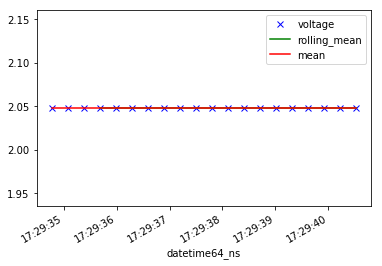

In [19]:
df[['voltage', 'rolling_mean', 'mean']].plot(style=[' xb', '-g', '-r']);

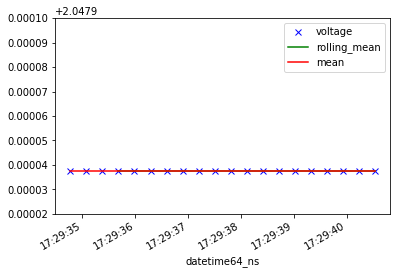

In [20]:
df[['voltage', 'rolling_mean', 'mean']].plot(style=[' xb', '-g', '-r'],
                                             ylim=(2.04792, 2.048));

In [21]:
print('Mean:', df_mean, 'Volts DC')
print('Standard Deviation:', df.voltage.std())

Mean: 2.0479375 Volts DC
Standard Deviation: 4.55625915701e-16


In [22]:
dt = df.index[-1]-df.index[0]
dtt = dt.seconds + dt.microseconds / 10**6
print('Sample Rate: {:.4f} Hz'.format(len(df)/dtt))

Sample Rate: 3.4736 Hz


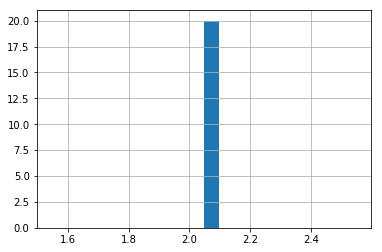

In [23]:
df.voltage.hist(bins=20);